# Lab 6 Multi-class Classification on FashionMNIST
You will 
- start doing image processing
- run NN models on GPUs
- use the `DataLoader()` class to iterate over dataset
- visualise images in the dataset
- train the model in batches
- print training and test accuracies
- perform some transformations on the dataset
- tweak the hyper parameters to help with model performance

**IMPORTANT: Change your runtime type to GPU before continuining.**



In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

### 0. Set up the device and hyper parameters

In [34]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # should print cuda, change your runtime type to GPU if not

# Hyper parameters
input_size = 784 # 28x28
hidden_size = 32 # can be removed if you prefer to specify this in the model's class itself
num_classes = 10
num_epochs = 5
batch_size = 32
learning_rate = 0.001

cuda


### 1. Load the dataset

In [24]:
# import data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=False, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))

# TODO: after downloading, locate the data within your hosted runtime machine in the folder on the left
# Q0. Type 'OK' below if you see a folder called 'FashionMNIST'
# OK

### View basic info on training data

In [25]:
print(f'Train set size: {len(train_set)}') # number of samples in training set
print(f'Labels: {train_set.targets}') # displays targets labels for the training data
print(f'Count of each class: {train_set.targets.bincount()}') 

# Q1. Considering the size of the training set and the batch size, how many iterations will there be in each epoch?
# 1875 iterations (60000/32)

# Q2. Is the dataset balanced? Why?
# yes. every class has 6000 data (equal)

Train set size: 60000
Labels: tensor([9, 0, 0,  ..., 3, 0, 5])
Count of each class: tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


### 2. Use DataLoader to load the datasets
If you get an error when you (re-)run the next code cell, then `restart the runtime` and run all code cells again.

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# Access the first data sample in the train_set using next(iter())
sample = next(iter(train_set))
print(f'Length: {len(sample)}')
print(f'Type: {type(sample)}')

# This means the data contains image-label pairs
# Unpack them
image, label = sample
# Same as these two lines:
# image = sample[0]
# label = sample[1]

# Print the shape and label of the first data sample
print(image.shape)
print(label)

# Q3. What does the shape of the image tell you about the number of channels and dimensions of the images?
# single channel with dimension 28x28

# Q4. What does the label value represent?
# it represent class (label would be classified)

Length: 2
Type: <class 'tuple'>
torch.Size([1, 28, 28])
9


### 3. Visualisation
View the first image

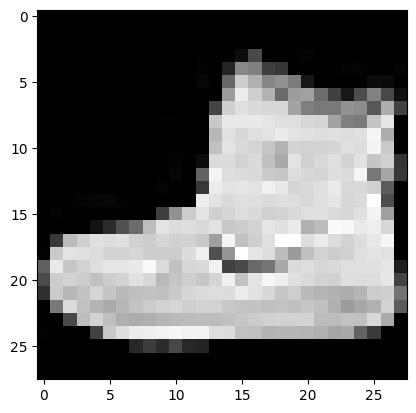

In [27]:
plt.imshow(image.squeeze(), cmap='gray')

In [28]:
# Get the first BATCH from train_loader
batch = next(iter(train_loader))
print(len(batch))
print(type(batch))

# Unpack the images and labels
images, labels = batch

print(f'Image shape: {images.shape}')
print(f'Label shape: {labels.shape}')

# Q5. What does each number in the shape of the images represent?
# it means 32 images in a single batch, one image size of 28x28

# Q6. What about the shape of the labels?
# 32 labels for each images

2
<class 'list'>
Image shape: torch.Size([32, 1, 28, 28])
Label shape: torch.Size([32])


### View some sample images
- The table for the label index and description is available [HERE](https://github.com/zalandoresearch/fashion-mnist#labels)

class labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3])


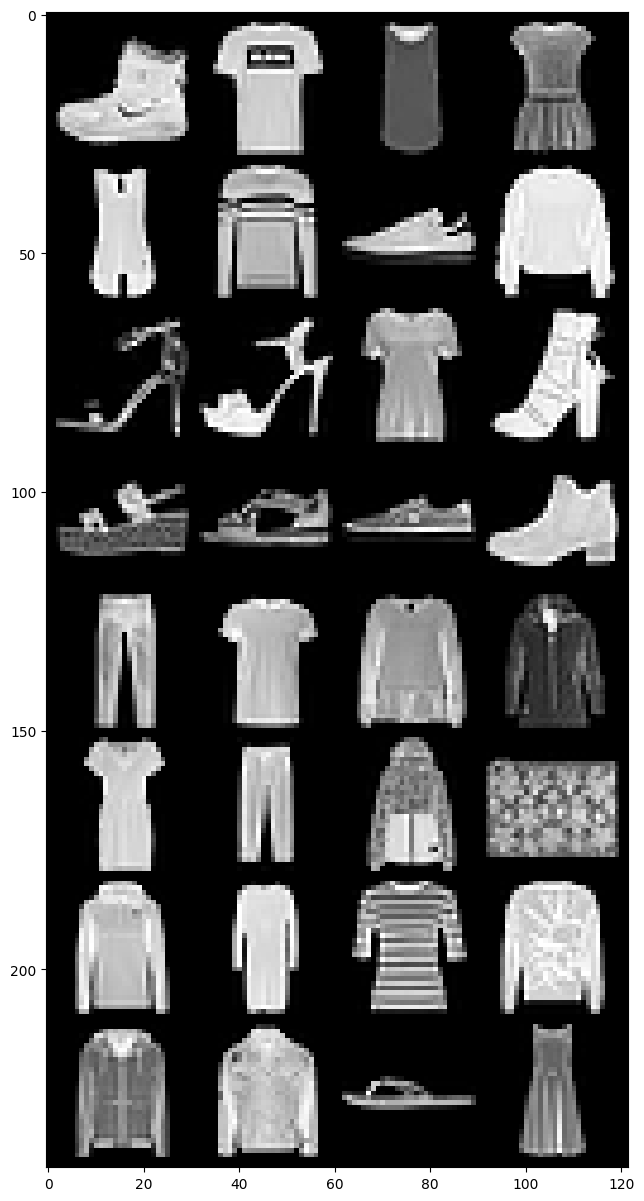

In [29]:
# Create a grid 
plt.figure(figsize=(15,15))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0), cmap='gray')


# Note that the images are grayscale (black and white) and have 28x28 pixels
# Grayscale images only have one channel
# TODO: Check that the image labels for each image corresponds to the correct label provided above

# Q7. How many images are displayed in total here and why? 
# 32, because batch size is 32
# Q8. How do you increase or decrease the TOTAL number of images displayed?
# change batch size

### 4. Define the Neural Network, Loss and Optimiser

In [35]:
# 4. NN model
class FashionNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, num_classes)
    # NOTE: softmax not added here because of CrossEntropyLoss later

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    return out

# 4.1 Create NN model instance
model = FashionNN(input_size, hidden_size, num_classes).to(device)

# 4.2 Loss and Optimiser
criterion = nn.CrossEntropyLoss() # will apply softmax
opt = optim.Adam(model.parameters(), lr=learning_rate)

### 5. Training Loop

In [36]:
# 5. Training loop
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

n_correct = 0
n_samples = 0

for epoch in range(num_epochs):
  print('\n')
  # 5.1 loop over all the batches, i is index, (images, labels) is data
  for i, (images, labels) in enumerate(train_loader):
    # 5.2 Reshape images first [batch_size, 1, 28, 28] --> [batch_size, 784]
    # 5.3 Push images to GPU
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # 5.4 Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # 5.5 Backward pass
    opt.zero_grad() # 5.6 Empty the values in the gradient attribute, or model.zero_grad()
    loss.backward() # 5.7 Backprop
    opt.step() # 5.8 Update params

    # 5.9 Print loss
    if (i+1) % 200 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')

    # 5.10 Get Accuracy
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (y_preds == labels).sum().item()

# 5.11 Print accuracy
acc = 100.0 * n_correct / n_samples
print(f'\nTrain Accuracy = {acc:.4f}')



Epoch 1/5, Iteration 200/1875, Loss=0.7606 
Epoch 1/5, Iteration 400/1875, Loss=0.4743 
Epoch 1/5, Iteration 600/1875, Loss=0.4069 
Epoch 1/5, Iteration 800/1875, Loss=0.6751 
Epoch 1/5, Iteration 1000/1875, Loss=0.3299 
Epoch 1/5, Iteration 1200/1875, Loss=0.3389 
Epoch 1/5, Iteration 1400/1875, Loss=0.7773 
Epoch 1/5, Iteration 1600/1875, Loss=0.4404 
Epoch 1/5, Iteration 1800/1875, Loss=0.4073 


Epoch 2/5, Iteration 200/1875, Loss=0.4464 
Epoch 2/5, Iteration 400/1875, Loss=0.3598 
Epoch 2/5, Iteration 600/1875, Loss=0.3662 
Epoch 2/5, Iteration 800/1875, Loss=0.5634 
Epoch 2/5, Iteration 1000/1875, Loss=0.2576 
Epoch 2/5, Iteration 1200/1875, Loss=0.2404 
Epoch 2/5, Iteration 1400/1875, Loss=0.7574 
Epoch 2/5, Iteration 1600/1875, Loss=0.3311 
Epoch 2/5, Iteration 1800/1875, Loss=0.3803 


Epoch 3/5, Iteration 200/1875, Loss=0.3710 
Epoch 3/5, Iteration 400/1875, Loss=0.3226 
Epoch 3/5, Iteration 600/1875, Loss=0.3664 
Epoch 3/5, Iteration 800/1875, Loss=0.5498 
Epoch 3/5, Itera

### 6. Evaluation

In [37]:
# 6. Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  # 6.1 Loop through test set
  for images, labels in test_loader:
    # 6.2 
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    # 6.3 Run on trained model
    outputs = model(images) 

    # 6.4. Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (y_preds == labels).sum().item()

  # 6.5 Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy = {acc:.4f}')

Test Accuracy = 85.9600


In [33]:
# Q9. What is the final loss of this model on the training set?
# 0.3831
# Q10. What is the accuracy of this model on the training set?
# 82.7525
# Q11. What is the accuracy of the trained model on the test set?
# 84.1300

### TASK: Increase `num_epochs` & redo
- Keep track of the loss and test set accuracy
- Set `num_epochs=5` in code cell 0 (hyper parameters)
- Rebuild and retrain the model by **running code cells 0, 4, and 5 ONLY**
- Evaluate the model on the test data by running **code cell 6**
- Answer the questions below

In [38]:
# Q12. What is the final loss now and is it less than the previous loss?
# 0.2778 (-0.1053)
# Q13. Are the training and test set accuracies higher now?
# 85.2200% for train set, 85.9600 % for train set (both are higher now)
# Q14. After changing the num_epochs, why should code cell 4 (NN, Loss, Optimiser) be run before code cell 5 (training)?
# reset the model and previously trained data

## 6. Let's add some improvements

We are going to add ONE improvement at a time
- First the training data is **normalised and shuffled** (code provided). Use the same number of epochs as the the previous case to make a fair comparison.
- Build and train the model and get the loss, train and test set accuracies.
- Then change ONE hyper parameter, e.g. `num_epochs`, `hidden_size`, `batch_size`, `learning_rate` OR add layers.
- Run code cells 7-11 to train and test the model and take note of its loss, train and test accuracies.

**IMPORTANT!** If you have trouble running any of the code cells below, restart the runtime, via `Runtime-->Restart runtime` before continuing (or `Ctrl/Cmd + M + .`)


In [ ]:
# You DO NOT have to run this cell code unless you restarted the runtime.

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

### 7. Normalise and Shuffle the Traning Data

In [39]:
# Add Normalisation to transform data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0,), (0.5,),)])

train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transform)
test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transform)


### 8a. Hyper-parameters

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
input_size = 784 # 28x28
hidden_size = 128
num_classes = 10 
num_epochs = 2
batch_size = 32
learning_rate = 0.001

cuda


### 8b. Shuffle the training data

This reshuffles the data at every epoch


In [103]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


### 9. NN Model, Loss, Optimiser

In [104]:
# 9. NN model
class FashionNN2(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, num_classes)
    # NOTE: softmax not added here because of CrossEntropyLoss later

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    return out

# 9.1 Create NN model instance
model = FashionNN2(input_size, hidden_size, num_classes).to(device)

# 9.2 Loss and Optimiser
criterion = nn.CrossEntropyLoss() # will apply softmax
opt = optim.Adam(model.parameters(), lr=learning_rate)

### 10. Training Loop

In [105]:
# 10. Training loop
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

n_correct = 0
n_samples = 0

for epoch in range(num_epochs):
  print('\n')
  # 10.1 loop over all the batches, i is index, (images, labels) is data
  for i, (images, labels) in enumerate(train_loader):
    # 10.2 Reshape images first [batch_size, 1, 28, 28] --> [batch_size, 784]
    # 10.3 Push images to GPU
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # 10.4 Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # 10.5 Backward pass
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

    # 10.6 Print loss
    if (i+1) % 200 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')

    # 10.7 Get model Accuracy
    # torch.max() returns actual probability value (ignored) and index of class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (y_preds == labels).sum().item()

# 10.8 Print accuracy
acc = 100.0 * n_correct / n_samples
print(f'Finished training \nTrain Accuracy = {acc:.4f}')




Epoch 1/2, Iteration 200/1875, Loss=0.4970 
Epoch 1/2, Iteration 400/1875, Loss=0.2882 
Epoch 1/2, Iteration 600/1875, Loss=0.5831 
Epoch 1/2, Iteration 800/1875, Loss=0.4096 
Epoch 1/2, Iteration 1000/1875, Loss=0.6023 
Epoch 1/2, Iteration 1200/1875, Loss=0.3138 
Epoch 1/2, Iteration 1400/1875, Loss=0.1496 
Epoch 1/2, Iteration 1600/1875, Loss=0.2961 
Epoch 1/2, Iteration 1800/1875, Loss=0.2687 


Epoch 2/2, Iteration 200/1875, Loss=0.2676 
Epoch 2/2, Iteration 400/1875, Loss=0.7251 
Epoch 2/2, Iteration 600/1875, Loss=0.9585 
Epoch 2/2, Iteration 800/1875, Loss=0.2591 
Epoch 2/2, Iteration 1000/1875, Loss=0.4605 
Epoch 2/2, Iteration 1200/1875, Loss=0.3231 
Epoch 2/2, Iteration 1400/1875, Loss=0.5271 
Epoch 2/2, Iteration 1600/1875, Loss=0.1771 
Epoch 2/2, Iteration 1800/1875, Loss=0.5312 
Finished training 
Train Accuracy = 84.4733


### 11. Evaluation on Test Set

In [106]:
# 11. Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  # 11.1 Loop through test set
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # 11.2 Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (y_preds == labels).sum().item()

  # 11.3 Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy = {acc:.4f}')


Test Accuracy = 85.5300


In [53]:
# Q15. What is the final loss of this model on the training set?
# 0.2877 
# Q16. What is the accuracy of this model on the training set?
# 83.2108
# Q17. What is the accuracy of the trained model on the test set?
# 84.4600
# Q18. Did shuffling and normalisation help to build a better model?
# yes. loss decreased while accuracy improved
# Q19. How many training samples were seen by the model during each epoch of training?
# 1875 samples each

### Further Improvement

- Try changing other hyper parameters, ONE at a time while keeping everything else the same
- **KEEP shuffling and normalisation**, i.e. do not change code cells 7 and 8b.
- Example changes:
  - Increase `num_epochs` (max 20)
  - Change number neurons in hidden layers (keep it within 128 max per layer)
  - Add ONE extra hidden layer at a time (start with 32 units). You only need to run code cells 9-11.
  - Change `batch_size` (to powers of 2s), try 64.
  - Change loss to `NLLLoss()`, you need to add softmax activation in the output layer
  - Change the learning rate

- Rerun **code cells 8a-11**(except when adding layers, where you would rerun just cells 9-11).
- If the change improves the model, KEEP this improvement and change something else and redo to see if it can be further improved.
- Keep a record of the final loss, train and test set accuracies for each test run.
- Make at LEAST THREE changes that help improve the model's performance on the test set.


In [ ]:
# Test 1 
# Change (e.g. num_epochs=10): num_epoches = 20  
# Loss: 0.2069 
# Train acc: 88.4965
# Test acc: 87.4600

In [ ]:
# Test 2 
# Change (e.g. batch_size=64): batch_size = 64
# Loss: 0.3657 
# Train acc: 82.4875
# Test acc: 84.6900

In [ ]:
# Test 3
# Change: neurons in hidden layers = 128
# Loss: 0.5312 
# Train acc: 84.4733
# Test acc: 85.5300

In [107]:
# Q20. State any insights you gained from this exercise.
# there are many ways to improve NN performance